# Notes
**Goal**: Recreate filters and convolution so as to get into the math and mechanics of things

**Progress** So far
- padding and creating kernels is straight forward
- Convolve operation doesn't seem to work entirely well. 
    - Doing color inversions instead of say edge detection 
    - Doing greylevel change as opposed to edge detection
    - Blurring seems to be doing nothing at all or some bit of sharpening
    - Operation too slow!!!!!
- Resolution <<< **increase kernel sizes to see effects**
    - Tried flipping the kernel in different directions + operating in int8 but still nada!
    - TODO: run with larger kernel sizes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage

import abc

In [2]:

class MyImage:
    def __init__(self, img_array):
        self.img_array = img_array #skimage.img_as_ubyte(img_array) ## save as int8
        
    def show(self, binz=8, cmapz='gray'):
        plt.subplot(1,2,1)
        plt.imshow( self.img_array , cmap=cmapz)
        plt.subplot(1,2,2)
        plt.hist(self.img_array.flatten(), bins=binz)
        plt.show();
        
    def stats(self):
        return f"Shape: {self.img_array.shape} \n \
                Mean: { np.mean( self.img_array )} \n \
                Median: {np.median( self.img_array )} \n \
                Max: {np.max( self.img_array )} \n \
                Min: {np.min( self.img_array )} "
        
class AFilter:
    @staticmethod 
    def pad(img, kern):
        w, h = img.shape 
        kw, kh = kern.shape
        pw, ph = (kw - 1)//2, (kh-1)//2
        
        pot = np.zeros( (w+pw*2, h+ph*2) )
        pot[ pw:-pw, ph:-ph] = img 
        
        return pot
    
    @staticmethod 
    def get_kern(k):
        ## flip 180 
        flipped = np.flip(k, 1)
        return flipped
    
    @staticmethod 
    def get_convolve_value(k, phood):
        ## sum of element-wise products
        return np.sum( k * phood)
        
    @abc.abstractmethod
    def apply(img, kern, padit=True):
        NotImplementedError
        
    @staticmethod 
    def convolve(img, kern, padit=True):         
        flipped_kern = AFilter.get_kern(kern)
                
        in_img = AFilter.pad(img, kern) if padit else img.copy() 
        output = np.zeros(in_img.shape)
        
        rowz, colz = in_img.shape 
        kw, kh = kern.shape
        
        ##TODO: fix padding/border-crossing
        for i in range(1, rowz+1):
            for j in range(1, colz+1):
                phood = in_img[ i:i+kw, j:j+kh ]
                output[ i, j] = AFilter.get_convolve_value(flipped_kern, phood)
                
                if (j+kh)>= colz:
                    break
            if (i+kw) >= rowz:
                break
        return output
    
    
class BaseFilter(AFilter):
    @staticmethod
    def apply(img, kern, padit=True):
        return AFilter.convolve(img, kern, padit)
        ## using numpy convolve << BUT is 1-D convolve
        ## return np.convolve(img, kern)
        

class MedianFilter(AFilter):    
    ##TODO: inheritance and static methods
    @staticmethod
    def apply(img, kern, padit=True):       
        flipped_kern = AFilter.get_kern(kern)
                
        in_img = AFilter.pad(img, kern) if padit else img.copy() 
        output = np.zeros(in_img.shape)
        
        rowz, colz = in_img.shape 
        kw, kh = kern.shape
        
        ##TODO: fix padding/border-crossing
        for i in range(1, rowz+1):
            for j in range(1, colz+1):
                phood = in_img[ i:i+kw, j:j+kh ]
                output[ i, j] = MedianFilter.get_convolve_value(flipped_kern, phood)
                
                if (j+kh)>= colz:
                    break
            if (i+kw) >= rowz:
                break
        return output
    
    ##TODO: inheritance and static methods 
    def get_convolve_value(k, phood):
        return np.median( phood.flatten() )
        
    
def make_gaussian_kern(size, sig=1):    
    ## size better if odd b/c balance
    ## The larger the size of the kernel, the lower the sensitivity to noise << i.e. more blur
    outk = np.zeros( (size, size) )
    
    k = (size-1)//2
    sig_const = 1/( 2 * np.pi * sig) 
    
    for i in range(size):
        for j in range(size):
            outk[i,j] = sig_const * np.exp( ( ( (i+1)-(k+1))**2 +( (j+1)-(k+1))**2 )*(-1/(2*sig)))
    return outk

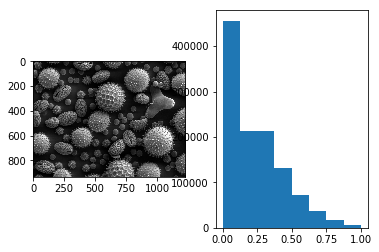

In [3]:
skimg2 = skimage.io.imread("media/pollen.jpg", as_gray=True)
my_img = MyImage(skimg2)

my_img.show()

# Blur Filters

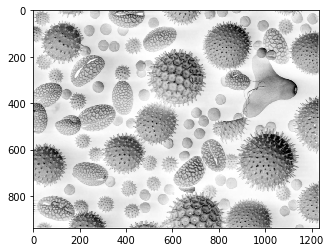

In [4]:
plt.imshow( BaseFilter.apply(my_img.img_array, -1*np.ones((3,3))*(1/9)), cmap='gray');

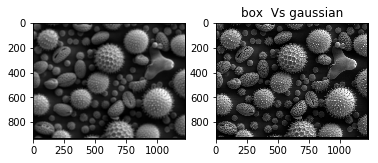

In [158]:
box_blur = BaseFilter.apply(my_img.img_array, np.ones((13,13))*(1/9), padit=False)

gaus_kern = np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])*(1/16)

gaus_kern = make_gaussian_kern(17)
gaus_blur = BaseFilter.apply(my_img.img_array, gaus_kern, padit=False)



plt.subplot(1,2,1)
plt.imshow(box_blur, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(gaus_blur, cmap='gray');

plt.title('box  Vs gaussian');

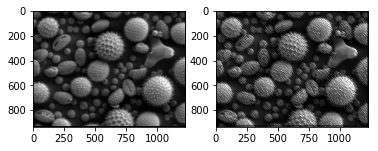

In [159]:
plt.subplot(1,2,1)
plt.imshow(my_img.img_array+box_blur, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(my_img.img_array+gaus_blur, cmap='gray');

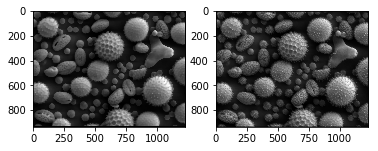

In [160]:
mblur = MedianFilter.apply(my_img.img_array, np.ones((13,13)), padit=False)

plt.subplot(1,2,1)
plt.imshow(mblur, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(my_img.img_array+mblur, cmap='gray');

# Edge Filters

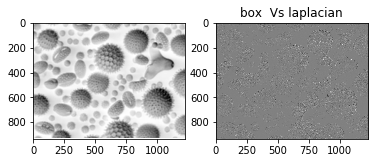

In [162]:
box_edge = BaseFilter.apply(my_img.img_array, -1*np.ones((13,13))*(1/9), padit=False)

laplacian_kern = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])
laplacian_edge = BaseFilter.apply(my_img.img_array, laplacian_kern, padit=False)


plt.subplot(1,2,1)
plt.imshow(box_edge, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(laplacian_edge, cmap='gray');

plt.title('box  Vs laplacian');

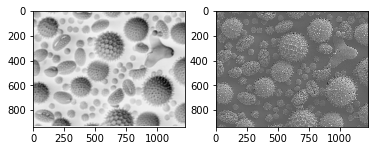

In [163]:
plt.subplot(1,2,1)
plt.imshow(my_img.img_array+box_edge, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(my_img.img_array+laplacian_edge, cmap='gray');

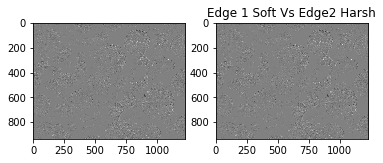

In [9]:
edge1_kern = np.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
])
edge1 = BaseFilter.apply(my_img.img_array, laplacian_kern, padit=False)

edge2_kern = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])
edge2 = BaseFilter.apply(my_img.img_array, laplacian_kern, padit=False)


plt.subplot(1,2,1)
plt.imshow(edge1, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(edge1, cmap='gray');

plt.title('Edge 1 Soft Vs Edge2 Harsh');

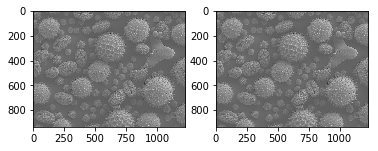

In [141]:
plt.subplot(1,2,1)
plt.imshow(my_img.img_array+edge1, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(my_img.img_array+edge2, cmap='gray');

-----

# SKImage

In [103]:
class AnImage:
    def __init__(self, src):
        self.img  =  skimage.color.rgb2gray(
                            skimage.io.imread(src)) 
        self.img = skimage.img_as_ubyte(self.img)
    @property
    def img_array(self):
        return self.img
    @property 
    def hist(self):
        #return np.histogram(self.img_array, bins=np.arange(0,256))
        hist, bins = skimage.exposure.histogram(self.img)
        #return hist
        return hist, bins
    
    def show(self):
        plt.subplot(1,2,1)
        plt.imshow(self.img, cmap='gray')
        plt.subplot(1,2,2)
        #plt.imshow(self.hist, cmap='gray');
        #plt.plot( self.hist );
        hist, bins = self.hist
        plt.plot( bins, hist/hist.max())

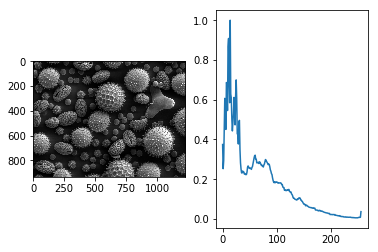

In [135]:
simg = AnImage("media/pollen.jpg")
simg.show()

In [100]:
# thresh = 30
# img = simg.img 


# plt.subplot(1,2,1)
# plt.imshow( img[ img <= thresh ].reshape(simg.img.shape[0], -1), cmap='gray')

# plt.subplot(1,2,2)
# plt.imshow( img[ img > thresh ].reshape(simg.img.shape[0], -1) , cmap='gray');

## Edge-based Segmentation

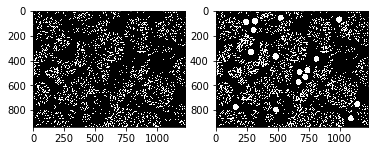

In [84]:
import scipy
from skimage.feature import canny

edges = canny( simg.img )
fillin = scipy.ndimage.binary_fill_holes(edges)

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(fillin, cmap='gray');

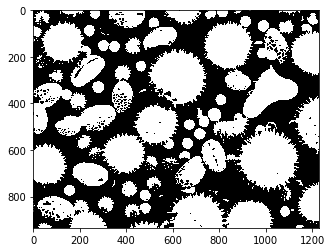

In [94]:
from skimage.segmentation import watershed
from skimage.filters import sobel 

elev = sobel(simg.img)

marks = np.zeros_like(simg.img)
marks[simg.img <30 ] = 1
marks[ simg.img >70] = 2

plt.imshow( watershed(elev, marks),cmap='gray'); 

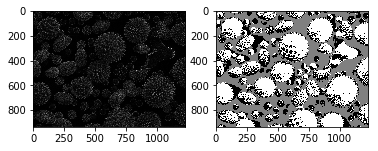

In [97]:
plt.subplot(1,2,1)
plt.imshow(elev, cmap='gray'); 
plt.subplot(1,2,2)
plt.imshow(marks, cmap='gray'); 

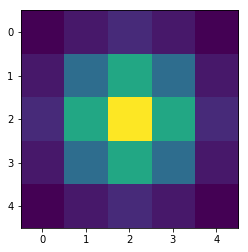

In [133]:
plt.imshow( make_gaussian_kern(5) ); 

-----
# Another Filters Section

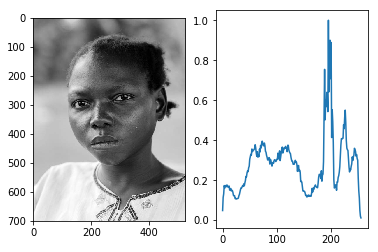

In [137]:
jimg = AnImage("media/img3.jpeg")
jimg.show()

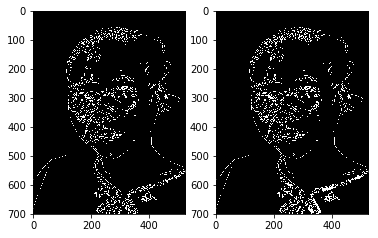

In [149]:
edges = canny( jimg.img )
fillin = scipy.ndimage.binary_fill_holes(edges)

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(fillin, cmap='gray');

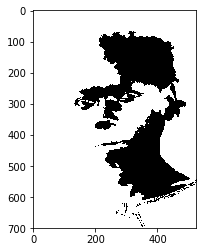

In [156]:
elev = sobel(jimg.img)

marks = np.zeros_like(jimg.img)
marks[jimg.img <30 ] = 1
marks[ jimg.img >100] = 2

plt.imshow( watershed(elev, marks),cmap='gray'); 